In [ ]:
from keras.layers import Dropout, Dense, GRU, Embedding
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.datasets import fetch_20newsgroups

In [ ]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open("./drive/My Drive/Colab Notebooks/glove.6B.50d.txt", encoding="utf8")
    for line in f:

        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.25):
    """
    def buildModel_RNN(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    word_index in word index ,
    embeddings_index is embeddings index, look at data_helper.py
    nClasses is number of classes,
    MAX_SEQUENCE_LENGTH is maximum lenght of text sequences
    """

    model = Sequential()
    hidden_layer = 3
    gru_node = 64

    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))


    print(gru_node)
    for i in range(0,hidden_layer):
        model.add(GRU(gru_node,return_sequences=True, recurrent_dropout=0.2))
        model.add(Dropout(dropout))
    model.add(GRU(gru_node, recurrent_dropout=0.2))
    model.add(Dropout(dropout))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))


    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
X_train = newsgroups_train.data
X_test = newsgroups_test.data
y_train = newsgroups_train.target
y_test = newsgroups_test.target

texts=[]

for x in X_train:
  texts.append(x)
for x in X_test:
  texts.append(x)
print(len(texts))

labels=[]

for x in y_train:
  labels.append(x)
for x in y_test:
  labels.append(x)
print(len(labels))

18846
18846


In [ ]:
nb_validation_samples = int(0.2 * len(texts))

x_train = texts[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = texts[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
X_train = newsgroups_train.data
X_test = newsgroups_test.data
y_train = newsgroups_train.target
y_test = newsgroups_test.target

X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)

Found 179209 unique tokens.
(18846, 500)
Total 400000 word vectors.


In [ ]:
model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 20)

model_RNN.summary()

64
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 50)           8960500   
_________________________________________________________________
gru_33 (GRU)                 (None, 500, 64)           22080     
_________________________________________________________________
dropout_33 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
gru_34 (GRU)                 (None, 500, 64)           24768     
_________________________________________________________________
dropout_34 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
gru_35 (GRU)                 (None, 500, 64)           24768     
_________________________________________________________________
dropout_35 (Dropout)         (None, 500, 64)       

In [ ]:
history=model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=50,
                              batch_size=256,
                              verbose=2)

predicted = model_RNN.predict_classes(X_test_Glove)

print(metrics.classification_report(y_test, predicted))

Train on 11314 samples, validate on 7532 samples
Epoch 1/50
 - 191s - loss: 2.9055 - acc: 0.0986 - val_loss: 2.7286 - val_acc: 0.1422
Epoch 2/50
 - 184s - loss: 2.5549 - acc: 0.1595 - val_loss: 2.2940 - val_acc: 0.2176
Epoch 3/50
 - 181s - loss: 2.1756 - acc: 0.2373 - val_loss: 1.9848 - val_acc: 0.3072
Epoch 4/50
 - 181s - loss: 1.8707 - acc: 0.3306 - val_loss: 1.7571 - val_acc: 0.3784
Epoch 5/50
 - 178s - loss: 1.5527 - acc: 0.4337 - val_loss: 1.5928 - val_acc: 0.4349
Epoch 6/50
 - 179s - loss: 1.2989 - acc: 0.5208 - val_loss: 1.5073 - val_acc: 0.4810
Epoch 7/50
 - 181s - loss: 1.0604 - acc: 0.6115 - val_loss: 1.4102 - val_acc: 0.5276
Epoch 8/50
 - 181s - loss: 0.8570 - acc: 0.6912 - val_loss: 1.3246 - val_acc: 0.5777
Epoch 9/50
 - 182s - loss: 0.6931 - acc: 0.7499 - val_loss: 1.3212 - val_acc: 0.6091
Epoch 10/50
 - 177s - loss: 0.5713 - acc: 0.7998 - val_loss: 1.3649 - val_acc: 0.6168
Epoch 11/50
 - 181s - loss: 0.4345 - acc: 0.8498 - val_loss: 1.3510 - val_acc: 0.6472
Epoch 12/50
 -

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

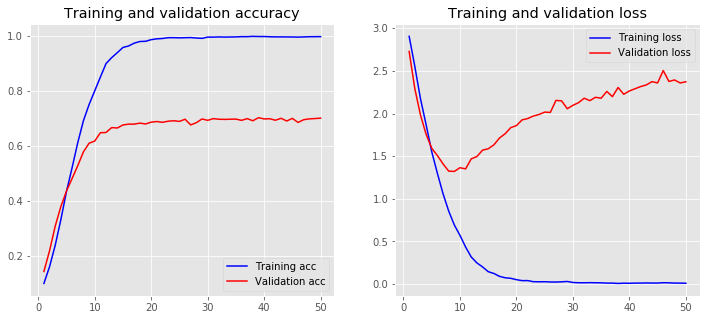

In [ ]:
plot_history(history)